
# What determines complaint success

**Motivation**: Development projects in developing countries can sometime harm local community (e.g. populating lands/water and desrupting local school activities or business). As a way to protect communities from detrimental projects, local communities can file complaints to different IAM (International Assistance Mission) organizations, which evaluate the complaints and decide if they will take action. However, it's unclear what determines whether a complaint is eligible for action. Finding this information can guide communities in filing future complaints. 

**Data**: Accountability Counsel providedd two datasets. 
 - Dataset 1 contains the 411 cases processed by 13 IAM organizations from 1994-2015 with 54 categories of case details.
 - Dataset 2 contains the 215 different case-evaluation criteria used by 7 out of the 13 IAM organizations. 
 
**Strategy**: As most of the data are non-numerical & incomplete, it's hard to directly feed all the data into a big model. Instead, I formed multiple targeted hypotheses that can be tested with defined subsets of the data. My hypotheses fall into two big propositions: 1) Case details determine case eligibility (Dataset 1). 2) Evaluation criteria determine case success (Correlation between Dataset 1 & 2).  

**End Product**: The number of issues raised for each complaint correlates with complaint success (Section 6). Accountability Counsel will include this finding in their written guide for filing complaints. 
 


# Section 1. Plot key statistics 

- import the csv
- plot eligible rate for each IAM (organizations)
- plot "nan" rate (where 'eligible' column has no numbers) for each IAM
- plot total number of complaint by each IAM

**Observation**: some IAMs have very limited number of cases, and thus not comparable to other IAMs. They are excluded from further analysis. 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# set directories 
csvdir = 'C:/Users/Huayi/Desktop/ac-datadive-2018-master/Data/'
acname = 'accountability_console_data_cleaned.csv' # dataset 1
bmname = 'benchmark_data_cleaned.csv' # dataset 2

# read csv 
acfull = pd.read_csv(csvdir+acname)
bm = pd.read_csv(csvdir+bmname)

# Take a look at the dataset 1
acfull.head()

,Complaint_Name,Project,Country_1,Country_2,Country_3,Country_4,IAM,Bank,External_ID,Status,...,Compliance_Review_Start,Compliance_Review_End,Compliance_Review_Status,If_No_Compliance_Report_Why,Monitoring_Start,Monitoring_End,Monitoring_Status,If_No_Monitoring_Why,Date_Closed,ELIGIBLE
0,4 MW Hydro Power Project Thack Chilas,4 MW Hydro Power Project Thack Chilas,Pakistan,NaN,NaN,NaN,ADB_SPF_CRP,Asian Development Bank,no_id_25_24,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,8/31/2013,0.0
1,Advanced Project Preparedness for Poverty Redu...,Advanced Project Preparedness for Poverty Redu...,India,NaN,NaN,NaN,ADB_SPF_CRP,Asian Development Bank,no_id_25_8,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,9/30/2012,0.0
2,Ak Altin Agricultural Development Project,Ak Altin Agricultural Development Project,Uzbekistan,NaN,NaN,NaN,ADB_SPF_CRP,Asian Development Bank,no_id_25_16,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,3/31/2013,0.0
3,Assam Integrated Flood and Riverbank Erosion a...,Assam Integrated Flood and Riverbank Erosion a...,India,NaN,NaN,NaN,ADB_SPF_CRP,Asian Development Bank,no_id_25_40,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,9/30/2015,0.0
4,Assam Power Sector Development Project,Assam Power Sector Development Project,India,NaN,NaN,NaN,ADB_SPF_CRP,Asian Development Bank,6-May,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,11/30/2006,0.0


In [11]:
# Take a look at dataset 2 
bm.head()

,Category,Benchmark,AfDB_IRM,ADB_SPF_CRP,EBRD_PCM,EIB_CM,IFC_CAO,IDB_MICI,OPIC_OA,WB_Panel
0,Budget,Does the mechanism prepare its own budget?,1,THE SPF'S BUDGET IS PROCESSED IN THE SAME WAY ...,1,1,0,1,NaN,NaN
1,Budget,Is the mechanism's budget approved by the Board?,NaN,THE SPF'S BUDGET IS PROCESS IN THE SAME WAY AS...,NaN,NaN,0,1,NaN,NaN
2,Budget,May the mechanism request additional funds if ...,NaN,"CRP, YES. FOR THE SPF, ANY ADDITIONAL HUMAN AN...",NaN,NaN,1,1,NaN,NaN
3,Compliance review findings or recommendations,Are claimants informed of draft findings befor...,0,1,1,1,0,1,0,0
4,Compliance review findings or recommendations,Are draft findings made available to claimant?,0,1,1,1,0,1,0,NaN


C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


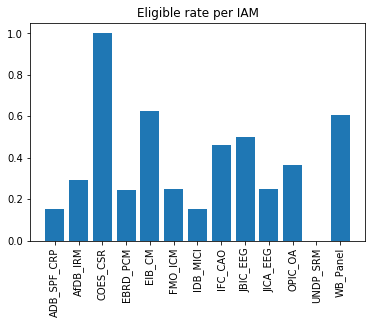

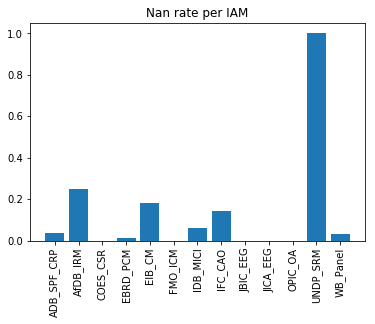

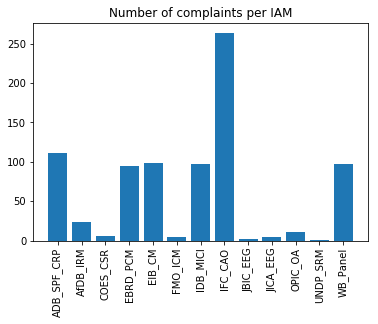

In [13]:
## Divide cases by IAM. 
# sort the list by 'IAM' (the collumn that contains names of the IAM organizations). 
acfull_1 = acfull.sort_values(by=['IAM'])

# find starting row of IAM by detecting where things change.  
stNo = [] # the number of strating row
nameLs = [] # the name of the IAM
for n, i in enumerate(acfull_1['IAM'].as_matrix()):
    if i != acfull_1['IAM'].as_matrix()[n-1]:
        nameLs.append([i]) 
        stNo.append([n])        
nameLs= np.array(nameLs).flatten() 

# the last row for each IAM
endNo =stNo[1:]; endNo.append([len(acfull_1)-1])

## determine success rate and 'nan' rate.
# row number where values are 'nan'
nanidx = np.argwhere(acfull_1['ELIGIBLE'].isna().values == 1)
eligs = acfull_1['ELIGIBLE'].values; eligs[nanidx]= 0 # set 'nan' to zero
nans = np.zeros(len(eligs)); nans[nanidx] = 1
# succ_rate is the same as eligible_rate
succ = np.zeros(len(stNo)); succ_rate = np.zeros(len(stNo)); nan_rate = np.zeros(len(stNo))
for n in np.arange(len(stNo)):
    succ[n] = np.sum(acfull_1['ELIGIBLE'].values[stNo[n][0]:endNo[n][0]])
    succ_rate[n] = succ[n]/(endNo[n][0] -  stNo[n][0])
    nan_rate[n] = np.sum(nans[stNo[n][0]:endNo[n][0]])/(endNo[n][0] -  stNo[n][0])
    
## plots
# eligible rate
plt.figure()
plt.bar(np.arange(len(stNo)),succ_rate)
plt.xticks(np.arange(len(stNo)), nameLs, rotation='vertical')
plt.title('Eligible rate per IAM')
plt.show()

# 'Nan'_rate 
plt.figure()
plt.bar(np.arange(len(stNo)),nan_rate)
plt.xticks(np.arange(len(stNo)), nameLs, rotation='vertical')
plt.title('Nan rate per IAM')
plt.show()

# number of complaints
NoC= (np.array(endNo) -  np.array(stNo)).flatten() 
plt.figure()
plt.bar(np.arange(len(stNo)),NoC)
plt.xticks(np.arange(len(stNo)), nameLs, rotation='vertical')
plt.title('Number of complaints per IAM')
plt.show()

# exporting the data s a csv file. 
# stats.csv contain 'IAM', 'eligible_rate', 'nan_rate','Complaint_Num' for all IAMs
stats = pd.DataFrame( np.matrix([nameLs, succ_rate, nan_rate, NoC]).transpose(), columns=['IAM', 'eligible_rate', 'nan_rate','Complaint_Num'])
stats['Complaint_Num'] = stats['Complaint_Num'].astype('float')
stats = stats.sort_values(by=['Complaint_Num'],ascending=False)
stats.to_csv(csvdir+'stats.csv')


# Section 2: focused correlation analysis on four IAMs

Based on the number of complaints per IAM, I identified 6 groups that have handled around 100 complaints or more.
Within these 6 groups, 2 IAMs ('ADB_SPF_CRP' & 'IDB_MICI') have the lowest eligible rate, another two ('EIB_CM'&'WB_Panel') have the highest eligible rate. 
These 4 IAMs are put into group1 & group2. I focus here on comparing if they have any correlation difference in evaluation criteria (benchmarked_data).

**The hypothesis**: if valuation criteria can directly predict eligible rate, then valuation criteria are more similar within groups, and more different btw the two groups. 

**The null hypothesis**: valuation criteria don't predict eligible rate directly; each IAM operates by their own unknown logic. 

**Conclusion**: based on the final plots, the correlation is all over the place. This supports the null hypothesis. 

In [18]:
## the 6 IAMs that have around 100 compaints or more.
## f_stats.csv contain 'IAM', 'eligible_rate', 'nan_rate','Complaint_Num' for the 6 IAMs
f_stats = stats.iloc[:6]
f_stats.to_csv(csvdir+'f_stats.csv')
f_stats_sorted = f_stats.sort_values(by=['eligible_rate'])
f_stats_sorted

,IAM,eligible_rate,nan_rate,Complaint_Num
0,ADB_SPF_CRP,0.15315315315315314,0.036036036036036036,111.0
6,IDB_MICI,0.15463917525773196,0.061855670103092786,97.0
3,EBRD_PCM,0.24210526315789474,0.010526315789473684,95.0
7,IFC_CAO,0.4600760456273764,0.14068441064638784,263.0
12,WB_Panel,0.6082474226804123,0.030927835051546393,97.0
4,EIB_CM,0.6262626262626263,0.18181818181818182,99.0


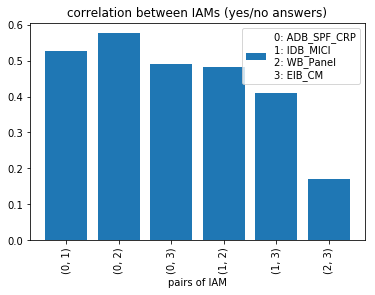

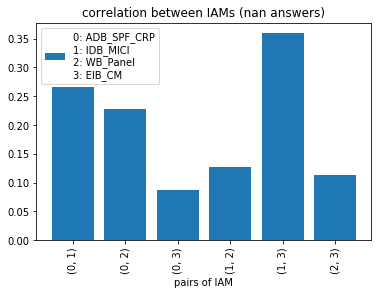

In [21]:
## seprate in to two groups. Gp1 has lowest eligible_rate, Gp2 has the highest. 
gp1 = f_stats_sorted['IAM'].values[:2]
gp2 = f_stats_sorted['IAM'].values[-2:]

## the code below drops out rows that has answers that are non-quantifiable ('nq') and nan.
# And it keeps track of how many rows are dropped. 
gps = np.append(gp1,gp2)
bm_gp = bm[gps]

# dropping non-quantifiable ('nq'), i.e. rows where it's not 'nan', or '1' or '0'
drop_idx = np.argwhere(np.sum(np.isin(bm_gp.values, ['1','0']) + bm_gp.isna().values, axis = 1) < 4 ) # row number
uq_percent = len(drop_idx)/len(bm_gp) # percentage of dropped for uq rows. 
bm_uqdropped = bm_gp.drop(index = drop_idx.flatten())

# drop rows where there is all 'nan'
allnan_idx = np.argwhere(np.sum(bm_uqdropped.isna().values, axis =1) ==4) # row number
allnan_idx= bm_uqdropped.index[allnan_idx.flatten()] # row number as index for the df
bm_uq_Anan_dropped = bm_uqdropped.drop(index=allnan_idx)

# amt & percentage of 'nan' in every column
nan_amt = np.sum(bm_uq_Anan_dropped.isna().values, axis =0)
nan_percent = nan_amt/ len(bm_uq_Anan_dropped)

# amt of rows that have all 0 or 1 answers in all columns 
ans_amt = np.sum(np.sum(np.isin(bm_uq_Anan_dropped.values, ['1','0']), axis =1) == 4)
ans_percent = ans_amt/ len(bm_uq_Anan_dropped)

# dropping rows that contain 3 or less 'nan'
nan_idx = bm_uq_Anan_dropped.index[np.argwhere(np.sum(np.isin(bm_uq_Anan_dropped.values, ['1','0']), axis = 1) < 4).flatten()]
bm_ans= bm_uq_Anan_dropped.drop(index = nan_idx)
bm_ans = bm_ans.astype('float')

####
# set where there is 'nan' to 1, and the rest to 0. 
bm_withnan = bm_uq_Anan_dropped
bm_withnan.values[np.isin(bm_withnan.values, ['1','0'])] = 0
bm_withnan.values[bm_withnan.isna()] = 1

####
# caculate correlation between every two IAMs & plot 
from itertools import combinations

# correlation for where all 4 answered either 0 or 1
comb = list(combinations(np.arange(len(gps)), 2))
corr = np.zeros(len(comb))
for n,i in enumerate(comb):    
    corr[n] = bm_ans[gps[i[0]]].corr(bm_ans[gps[i[1]]])
    
plt.figure()
plt.bar(np.arange(len(comb)), corr)
plt.xticks(np.arange(len(comb)), comb, rotation='vertical')
plt.legend(['0: %s'%gps[0] +'\n1: %s'%gps[1] + '\n2: %s'%gps[2] + '\n3: %s'%gps[3]])
plt.xlabel('pairs of IAM')
plt.title('correlation between IAMs (yes/no answers)')
plt.show()

# correlation for where they answered 'nan'
bm_withnan = bm_withnan.astype('float')
corr_withnan = np.zeros(len(comb))
for n,i in enumerate(comb):    
    corr_withnan[n] = bm_withnan[gps[i[0]]].corr(bm_withnan[gps[i[1]]])
    
plt.figure()
plt.bar(np.arange(len(comb)), corr_withnan)
plt.xticks(np.arange(len(comb)), comb, rotation='vertical')
plt.legend(['0: %s'%gps[0] +'\n1: %s'%gps[1] + '\n2: %s'%gps[2] + '\n3: %s'%gps[3]])
plt.title('correlation between IAMs (nan answers)')
plt.xlabel('pairs of IAM')
plt.show()


# Section 3: Categorical correlations 

Since Section2 supports the null hypothesis, I explored that idea that maybe group 1 & 2 differ by answers to questions in each category of evaluation criteria. Here I summed the answers in each category and ran a correlation analysis between the two groups. 

**Conclusion**: based on the plots, categorical sums don't predict eligible_rate directly. 

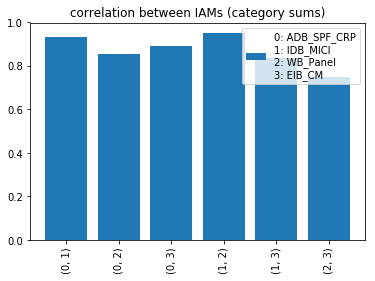

In [22]:
## the code below try to parse out where each category start &  end 
bm_cat = bm['Category'].loc[bm_ans.index]
cat_idx = []
for n, i in enumerate(bm_cat.values):
    if i != bm_cat.values[n-1]:
        cat_idx.append(n)
        
#bm_cat.loc[cat_idx]    
cat_idx_end = cat_idx[1:]
cat_idx_end.append(len(bm_cat))

# category names 
sub_cat = bm_cat.values[cat_idx] 
# categorical sums 
cat_score = np.zeros([len(cat_idx),4])
for i in np.arange(len(cat_idx)):
    cat_score[i,:] = np.sum(bm_ans.values[cat_idx[i]:cat_idx_end[i],:], axis = 0)

## correlation btw every 2 IAMs. 
corr_cat = np.zeros(len(comb))
for n,i in enumerate(comb):    
    corr_cat[n] = np.corrcoef(cat_score[:,i[0]], cat_score[:,i[1]])[1,0]

## plot correlations 
plt.figure()
plt.bar(np.arange(len(comb)), corr_cat)
plt.xticks(np.arange(len(comb)), comb, rotation='vertical')
plt.legend(['0: %s'%gps[0] +'\n1: %s'%gps[1] + '\n2: %s'%gps[2] + '\n3: %s'%gps[3]])
plt.title('correlation between IAMs (category sums)')
plt.show()


# Section 4: focus on 'eligibility requirements'

Since 'Eligibility requirements' are more decisive on if a project is eligible, here I looked compared answers under this category between group 1 & 2. 

**Conclusion**: despite what the correlation plot shows, the two groups have almost answered '1' on all questions. I don't think the difference in this category can separate the two groups. 

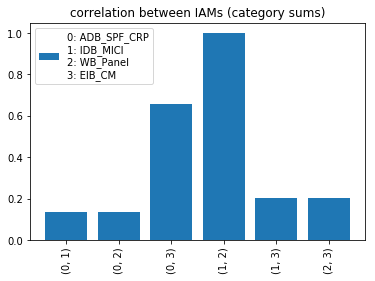

In [23]:
##'Eligibility requirements'
er_idx = bm_cat.index[bm_cat == 'Eligibility requirements']
er = bm_ans.iloc[er_idx]

# added tiny difference to avoide "division by 0" problem
tiny = np.asarray([0, 1e-15, 0,0,0,0,0,0])

## correlation btw every 2 IAMs. 
corr_er = np.zeros(len(comb))
for n,i in enumerate(comb):    
    corr_er[n] = (er[gps[i[0]]]+tiny).corr(er[gps[i[1]]]+tiny)

## plot correlations 
plt.figure()
plt.bar(np.arange(len(comb)), corr_er)
plt.xticks(np.arange(len(comb)), comb, rotation='vertical')
plt.legend(['0: %s'%gps[0] +'\n1: %s'%gps[1] + '\n2: %s'%gps[2] + '\n3: %s'%gps[3]])
plt.title('correlation between IAMs (category sums)')
plt.show()

# Section 5: the most different categories & benchmarks between two groups 

Are there categories/ evaluation criteria (benchmarks) that are the same within a group but different between groups? 
i.e. are there critical categories/ benchmarks that segregate the two groups? 

**Conclusion**: 
- The category 'Functions' is the same for two IAMs in group1, not group2. No category satisfies this condition for group2. 
- One benchmark that satisfies this condition for the two groups:
    - Benchmark: "Must the claim be brought for direct harm by the institution?"
    - This is under the category: "Project-related scope and limitations of mechanism" 

In [28]:
# find category that has same total score for the two IAMs in group1, but differ from group2. 
gp1_diff_idx = np.argwhere((cat_score[:,0] == cat_score[:,1]) & (cat_score[:,0] != cat_score[:,2]) & (cat_score[:,0] != cat_score[:,3]))
gp1_diff_cat = sub_cat[gp1_diff_idx]
print(gp1_diff_cat)

# find category that has same total score for the two IAMs in group2, but differ from group1. 
gp2_diff_idx = np.argwhere((cat_score[:,2] == cat_score[:,3]) & (cat_score[:,2] != cat_score[:,0]) & (cat_score[:,2] != cat_score[:,1]))
gp2_diff_cat = sub_cat[gp2_diff_idx]
print(gp2_diff_cat)


[['Functions']]
[]


In [29]:
# find benchmark that has same total answers for the two IAMs in group1, but differ from group2. 
gp1_qn_idx = np.argwhere((bm_ans.values[:,0] == bm_ans.values[:,1]) & (bm_ans.values[:,0] != bm_ans.values[:,2]) & (bm_ans.values[:,0] != bm_ans.values[:,3]))
gp1_idx  = bm_ans.index[gp1_qn_idx]
print(gp1_idx)

# find benchmark that has same total answers for the two IAMs in group2, but differ from group1. 
gp2_qn_idx = np.argwhere((bm_ans.values[:,2] == bm_ans.values[:,3]) & (bm_ans.values[:,2] != bm_ans.values[:,0]) & (bm_ans.values[:,2] != bm_ans.values[:,1]))
gp2_idx  = bm_ans.index[gp2_qn_idx]
print(gp2_idx)

# print this common benchmark and the category. 
print('Category:', bm.iloc[gp2_idx[0][0]]['Category'], '\n', 'Benchmark:', bm.iloc[gp2_idx[0][0]]['Benchmark'])

Int64Index([[126]], dtype='int64')
Int64Index([[126]], dtype='int64')
Category: Project-related scope and limitations of mechanism 
 Benchmark: Must the claim be brought for direct harm by the institution?


# Section 6: Number of issues per case per IAM

The analysis so far indicates that dataset2 on evaluation criteria does not predict IAM eligible rate. This implies that the difference in IAM eligible rate may depend on what kind of cases they receive instead of their standards in processing them. 

- I computated the number of issues per case per IAM. 
- the number of cases that have 2 or more issues per IAM.
- 3 or more, 4 or more

**Conclusion**: 
- Group2, which has a higher eligible rate, has more issues per case. 
- Group2 also has more cases that have 2 or more issues. 

In [30]:
# list of columns containing "issues"

issues = ["Issues_1", "Issues_2", "Issues_3", "Issues_4", "Issues_5", "Issues_6", "Issues_7", "Issues_8", "Issues_9", "Issues_10"]
issNo = 10-np.sum(acfull_1[issues].isna(),axis=1)


# No of issues per IAM 
issSum = np.zeros(len(stNo))
issPerC = np.zeros(len(stNo))
issM2rate = np.zeros(len(stNo))
issM3rate = np.zeros(len(stNo))
issM4rate = np.zeros(len(stNo))
for n in np.arange(len(stNo)):
    issSum[n] = np.sum(issNo[stNo[n][0]:endNo[n][0]])
    # total number of cases = number of rows - those that had 'nan' in 'eligible'
    caseNo = (endNo[n][0] -  stNo[n][0])-np.sum(nans[stNo[n][0]:endNo[n][0]])/(endNo[n][0] -  stNo[n][0])
    issPerC[n] = issSum[n]/caseNo                            
    issM2rate[n] = np.sum(issNo[stNo[n][0]:endNo[n][0]] > (2-1))/caseNo
    issM3rate[n] = np.sum(issNo[stNo[n][0]:endNo[n][0]] > (3-1))/caseNo
    issM4rate[n] = np.sum(issNo[stNo[n][0]:endNo[n][0]] > (4-1))/caseNo

C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


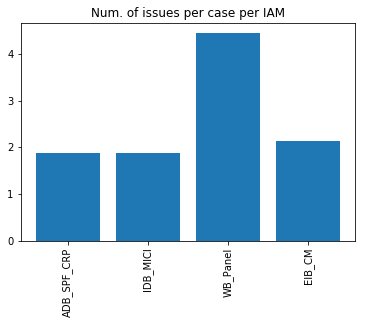

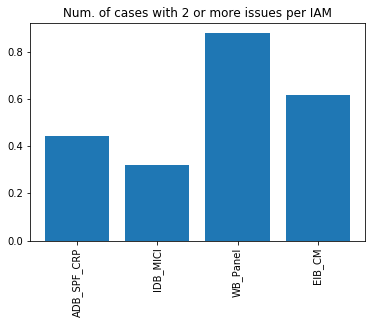

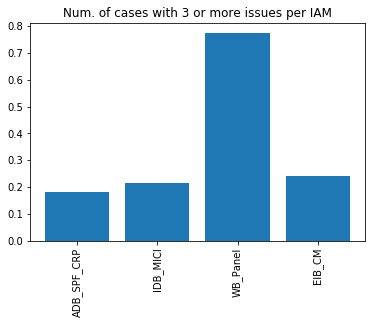

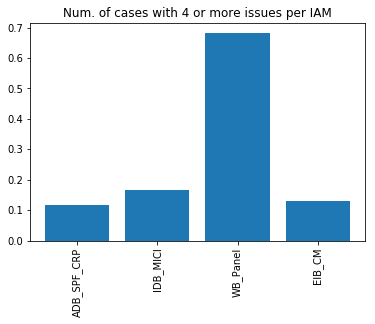

In [31]:
# Find issues per case for the 4 IAMs
issueNo = np.array([issPerC[nameLs =='ADB_SPF_CRP'],  issPerC[nameLs =='IDB_MICI'], issPerC[nameLs =='WB_Panel'], issPerC[nameLs =='EIB_CM']])
M2rate = np.array([issM2rate[nameLs =='ADB_SPF_CRP'],  issM2rate[nameLs =='IDB_MICI'], issM2rate[nameLs =='WB_Panel'], issM2rate[nameLs =='EIB_CM']])
M3rate = np.array([issM3rate[nameLs =='ADB_SPF_CRP'],  issM3rate[nameLs =='IDB_MICI'], issM3rate[nameLs =='WB_Panel'], issM3rate[nameLs =='EIB_CM']])
M4rate = np.array([issM4rate[nameLs =='ADB_SPF_CRP'],  issM4rate[nameLs =='IDB_MICI'], issM4rate[nameLs =='WB_Panel'], issM4rate[nameLs =='EIB_CM']])

#Plot
plt.figure()
plt.bar(np.arange(4),issueNo.flatten())
plt.xticks(np.arange(4), gps, rotation='vertical')
plt.title('Num. of issues per case per IAM')
plt.show()

plt.figure()
plt.bar(np.arange(4),M2rate.flatten())
plt.xticks(np.arange(4), gps, rotation='vertical')
plt.title('Num. of cases with 2 or more issues per IAM')
plt.show()

plt.figure()
plt.bar(np.arange(4),M3rate.flatten())
plt.xticks(np.arange(4), gps, rotation='vertical')
plt.title('Num. of cases with 3 or more issues per IAM')
plt.show()

plt.figure()
plt.bar(np.arange(4),M4rate.flatten())
plt.xticks(np.arange(4), gps, rotation='vertical')
plt.title('Num. of cases with 4 or more issues per IAM')
plt.show()